2021.11.9

#  Sound Effects Tagging


## Goal
the task is to annotate or tag a sound with descriptive (semantic) keywords.  This kind of content-based tagging system could be useful to musicians and sound engineers who want to automatically organize their sound library, or search for sounds by keyword.


## Methodology
Semantic annotation is a multi-label classification problem, where each label corresponds to one sound tag and is a binary classification problem. The labels can co-occur (multiple labels can be assigned to the same sound), which makes it different from multi-class classification (where only one label can be assigned).  Sound is a temporal process, so the important thing is how to define the _feature space_ for representing the sound, before learning the binary classifiers. You are free to choose appropriate methods (e.g., feature extraction method, dimensionality reduction, and clustering methods) to help define a suitable feature space for sound annotation.You can also consider the co-occurence of the labels to help with the multi-label classification.


## Evaluation of Tagging

For evaluation, you will predict the presence/absence of tags for each test sound. The evaluation metric is "Mean column-wise AUC".  AUC is the area under the ROC curve, which plots FPR vs TPR.  "Mean column-wise" computes the average of the AUCs for the tags.  To compute AUC, you will need to predict the score of each label (e.g., decision function value, probability, etc.) rather than the label.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. The entry with the highest final ranking will win a prize!  Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.


**Note:** You can only submit 2 times per day to Kaggle!


<hr>

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display

In [2]:
def showAudio(info):
    display(Audio(info['previews']['preview-lq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training and test data are stored in various pickle files.
The below code will load the data.

In [3]:
train_tags  = load_pickle('train_tags.pickle3')
train_mfccs = load_pickle('train_mfccs.pickle3')
train_info  = load_pickle('train_info.pickle3')

test_mfccs = load_pickle('test_mfccs.pickle3')
test_info  = load_pickle('test_info.pickle3')

Here are the things in the dataset:

- `train_info` - info about each sound in the training set (contains a link to the sound).
- `train_mfccs` - the MFCC features for each sound in the training set.  MFCCs are [Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a type of spectral feature vector for audio.
- `train_tags` - the descriptive tags for each sound in the training set. Tags have already been stemmed.
- `test_info` - info about each sound in the test set.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the first sound in the training set, as well as the tags.

In [5]:
showAudio(train_info[0])
print(train_tags[0])

['metal']


and here are the MFCCs for the first sound in the training set.  The MFCC vectors are 13-dimensions each, and they are extracted using a sliding window over the sound.

(345, 13)


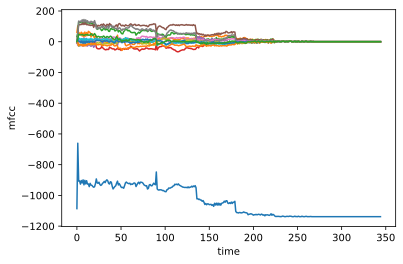

In [4]:
print(train_mfccs[0].shape)
plt.plot(train_mfccs[0]);
plt.xlabel('time')
plt.ylabel('mfcc');

In [7]:
train_mfccs[2].shape

(320, 13)

## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.


In [5]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [6]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [11]:
print(train_dmfccs[0][0])


[-1.08599561e+03  6.16124954e+01  3.26212196e+01  4.88774490e+00
 -9.12226868e+00 -8.47605133e+00 -7.11513519e-01  4.72403717e+00
  3.38615799e+00 -1.22250366e+00 -2.96123886e+00 -7.83477783e-01
  1.45116425e+00  4.25331665e+02  4.10426712e+01  2.63916092e+01
  2.21846256e+01  1.22690163e+01  5.83558960e+01 -2.38054867e+01
  3.96332779e+01 -1.63995991e+01  1.71343832e+01  1.39941864e+01
 -2.17901421e+00  1.58920860e+01]


## Data Pre-processing - bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and map each MFCC to one of the words.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [7]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(391816, 26)


In [8]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487, n_init=10)
km.fit(all_dmfccs[0::10])  # subsample by 10 to make it faster
km.cluster_centers_

array([[-6.33231584e+02,  2.07206632e+02, -6.25408128e+01, ...,
        -3.03311023e-01, -1.25701009e-01, -2.74165929e-01],
       [-9.23504888e+02,  1.08829412e+02, -2.91526785e+00, ...,
        -3.27465306e+00,  8.16632228e-01,  9.92210686e-01],
       [-1.11604742e+03,  2.53642309e+01,  2.16131104e+01, ...,
        -4.40327555e-01, -3.18936326e-01, -2.54758205e-01],
       ...,
       [-9.62797251e+02, -1.43195909e+02,  1.33798467e+01, ...,
        -9.05579559e-01,  1.34872622e+00,  4.92219448e-02],
       [-7.74567106e+02,  2.96196509e+01, -5.88479305e-01, ...,
         4.46892107e+00,  1.30115337e+00,  6.71524096e+00],
       [-8.16680433e+02,  1.33527529e+02, -1.22179913e+02, ...,
         4.36383962e-04,  1.35829113e-02,  1.77175870e-01]])

Now transform the data into BOW.

In [9]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [10]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

# Tag pre-processing

Next, we extract all the tags from the data, and get a unique list of tags.

In [11]:
tagnames, tagnames_counts = unique(concatenate(train_tags), return_counts=True)
for a,b in zip(tagnames, tagnames_counts):
    print("{}: {}".format(a, b))

acoust: 100
analog: 100
bass: 160
beat: 128
drum: 371
effect: 141
electron: 194
field: 110
glitch: 110
guitar: 130
hit: 110
loop: 237
machin: 100
metal: 117
nois: 199
percuss: 285
record: 192
space: 125
synth: 220
synthes: 136
vocal: 120
voic: 167


Now we convert the list of tags for each sound into binary attributes.

In [12]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [13]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
train_classes = tags2class(train_tags, tagnames)
train_tags

[['metal'],
 ['synth'],
 ['loop'],
 ['glitch'],
 ['voic'],
 ['metal'],
 ['metal'],
 ['metal'],
 ['analog'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['acoust', 'percuss'],
 ['guitar'],
 ['guitar'],
 ['guitar'],
 ['guitar'],
 ['guitar'],
 ['guitar'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['glitch'],
 ['glitch'],
 ['glitch'],
 ['glitch'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['space', 'loop'],
 ['guitar', 'bass'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['electron'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['synth'],
 ['guitar', 'acoust'],
 ['guita

In [14]:
# double check we did this correctly...
# it should be the same as the tag counts above
sum(train_classes,axis=0)
train_classes.shape

(1788, 22)

## Baseline experiments

Next, we will run a baseline experiment doing semantic tagging with bag-of-audio words.

Apply TF-IDF to the count vectors.

In [15]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
# tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2',smooth_idf=True)
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

Now learn a logisic regression classifier for each tag.

In [247]:
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, class_weight='balanced', solver='liblinear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

training 0 - acoust
training 1 - analog
training 2 - bass
training 3 - beat
training 4 - drum
training 5 - effect
training 6 - electron
training 7 - field
training 8 - glitch
training 9 - guitar
training 10 - hit
training 11 - loop
training 12 - machin
training 13 - metal
training 14 - nois
training 15 - percuss
training 16 - record
training 17 - space
training 18 - synth
training 19 - synthes
training 20 - vocal
training 21 - voic


To see how we did on tagging the training set, we compute the tag scores.

In [39]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

    

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


array([ -0.23099222, -11.07729787,  -0.08299242,  -3.4345911 ,
         0.29382914,   0.15170868,  -0.83832134,  -0.44425194,
        -3.43727508,  -0.27167284,   0.09417186,  -1.49882361,
        -0.21002411,   0.17738926,   0.08815112,   0.07565142,
        -0.28097507,  -0.51049543,  -2.61785619,  -0.39915735,
        -0.84548407,  -1.26232105])

And then plot the ROC curve using the training classes and training predicted scores.

In [36]:
# plot an ROC curve using class labels and class scores
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))

    plt.grid(True)

In [145]:
train_classes.shape

(1788, 22)

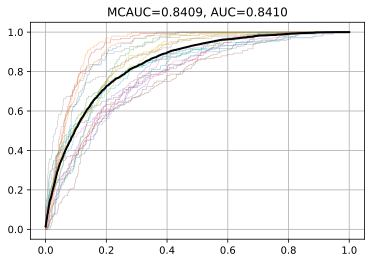

In [36]:
plot_roc(tagnames, train_classes, train_predscore)

Note that AUC is the AUC of the black curve, while MCAUC is the average of the AUCs for all the color curves.

Now apply the LR classifiers to the test set to predict the score for each tag.

In [40]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


We have the scores, now lets look at the predicted tags.

In [41]:
# convert binary class vector into a list of tags
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        tags.append(" ".join(tmp))
    return tags

We need to convert the score into a binary class label using a threshold (usually 0).

In [42]:
# convert score into binary class 0 or 1.  
test_predclass = test_predscore>0

# convert to tags
test_predtags = class2tags(test_predclass, tagnames)

In [43]:
# view tags for one example
print(test_predtags[0])
showAudio(test_info[0])

drum effect electron hit metal nois percuss


Now write the tag scores for the test set for submission to Kaggle.

In [51]:
import csv

def write_csv_kaggle_tags(fname, tagnames, Yscores):
    # header
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

In [ ]:
write_csv_kaggle_tags("sounds_test_kaggle_bow_baseline.csv", tagnames, test_predscore)

## YOUR CODE and DOCUMENTATION HERE

First,we dont apply any demension reduce tech and  data processing tech other than MFCC and see the result.
Since we have large demension and conclude time sequence factor, thus the data is likely to be non-linear and unexplainable.So we use **keras's Simple NN model** at first to see the baseline of nerual network

note:because this is a multi-label problem, so we should use sigmoid as output activcation and binary_crossentropy to train the model

In [16]:
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.sparse import csr_matrix


# 获取数据集
X = train_Xtf.toarray()
y = train_classes

print(train_Xtf.shape)
print(y.shape)
assert X.shape[0] == y.shape[0]

# 把数据集分为训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=11,shuffle=True)


(1788, 100)
(1788, 22)


In [494]:
# NN model
from keras import Sequential
from keras.layers import Dense
import keras
from tensorflow.keras import optimizers

model = Sequential()

# add 3 simple dense layer
model.add(Dense(500, activation='relu', input_shape=(train_Xtf.shape[1],)))
model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) #prevent overfitting
model.add(Dense(22, activation='sigmoid'))

# for multi-label classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
history = model.fit(X_train, Y_train, batch_size=100, epochs=50, verbose=1,
                   validation_data=(X_test, Y_test))

predict = model.predict(X_test)

Epoch 1/50
13/13 [==============================] - 1s 19ms/step - loss: 0.6206 - auc: 0.5295 - val_loss: 0.4279 - val_auc: 0.5721
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3522 - auc: 0.5353 - val_loss: 0.3197 - val_auc: 0.6000
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3112 - auc: 0.5960 - val_loss: 0.3015 - val_auc: 0.6060
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3034 - auc: 0.5981 - val_loss: 0.2939 - val_auc: 0.6151
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3000 - auc: 0.6127 - val_loss: 0.2920 - val_auc: 0.6197
Epoch 6/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2970 - auc: 0.6277 - val_loss: 0.2913 - val_auc: 0.6218
Epoch 7/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2942 - auc: 0.6412 - val_loss: 0.2897 - val_auc: 0.6335
Epoch 8/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2922 - auc: 0.6

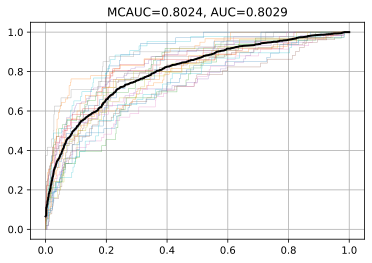

In [495]:
plot_roc(tagnames, Y_test, predict)

In [356]:
# test the baseline algorithm  in kaggle for NN
model.fit(X, y, batch_size=100, epochs=50, verbose=1)
test_predict = model.predict(test_Xtf.toarray())
write_csv_kaggle_tags("sounds_test_kaggle_bow_baseline.csv", tagnames, test_predict)

Epoch 1/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1803 - auc: 0.9108
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1691 - auc: 0.9226
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1631 - auc: 0.9310
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1592 - auc: 0.9350
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1550 - auc: 0.9385
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1506 - auc: 0.9443
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1482 - auc: 0.9462
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1440 - auc: 0.9494
Epoch 9/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1414 - auc: 0.9523
Epoch 10/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1383 - auc: 0.9543
Epoch 11/50
18/18 [==============================] - 0s 3ms/step - lo

By **Simple NN model** we get 0.79 on kaggle which is just above the baseline.From my perspective,it's because the simple dense layer can't stimulate the complex time-sequnece variance,we should add Convolution layer and dropout layer to let network learn this.So, we test the **CNN Model** 's baseline  

**CNN STRUCTURE:**

1) Conv1D layer do sliding window convolution on two-dimensional input

2) MaxPooling1D layer to maximum pooling of airspace signals

3) Dropout layer to prevent overfitting


we use a simple CNN model which have 2 Conv1D and 2 dense layer plus dropout layer to prevent overfitting,the activation function is relu for better formance

we also degisn a complex CNN model with more layers,but it has lower perfomance

In [296]:
# CNN model
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D
from keras import regularizers

input_shape = (1,X_train.shape[0],X_train.shape[1])



CNN_model = Sequential()
CNN_model.add(Conv1D(256,3,activation='relu',input_shape=(X_train.shape[1],1))) # 卷积层1
CNN_model.add(Conv1D(128,2, activation='relu',padding='same')) #卷积层2
CNN_model.add(MaxPooling1D(pool_size=2)) #池化层
# CNN_model.add(Dropout(0.2)) #神经元随机失活 
CNN_model.add(Flatten()) #拉成一维数据
CNN_model.add(Dense(128, activation='relu'))#全连接层
# CNN_model.add(Dropout(0.2)) #随机失活
CNN_model.add(Dense(22, activation='sigmoid')) #output layer


# complex CNN with more layer (but lower AUC)

# CNN_model.add(Conv1D(256,5,activation='relu',input_shape=(X_train.shape[1],1)))
# CNN_model.add(Conv1D(128,5,padding='same',activation='relu'))
# # CNN_model.add(Dropout(0.2))
# CNN_model.add(MaxPooling1D(pool_size=(2)))
# CNN_model.add(Conv1D(128,5,activation='relu',padding='same'))
# # CNN_model.add(Dropout(0.2))
# CNN_model.add(Conv1D(128,5,activation='relu',padding='same'))
# # CNN_model.add(Dropout(0.2))
# CNN_model.add(Conv1D(128,5,padding='same',activation='relu'))
# # CNN_model.add(Dropout(0.2))
# CNN_model.add(MaxPooling1D(pool_size=(3)))
# CNN_model.add(Conv1D(256,5,padding='same',activation='relu'))
# # CNN_model.add(Dropout(0.2))
# CNN_model.add(Flatten())
# CNN_model.add(Dense(22,activation='sigmoid'))

CNN_X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
CNN_X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))


CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
history = CNN_model.fit(CNN_X_train, Y_train, batch_size=100, epochs=40, verbose=1,validation_data=(CNN_X_test, Y_test))


Epoch 1/40
13/13 [==============================] - 1s 42ms/step - loss: 0.5364 - auc: 0.5261 - val_loss: 0.3578 - val_auc: 0.5547
Epoch 2/40
13/13 [==============================] - 0s 32ms/step - loss: 0.3272 - auc: 0.5720 - val_loss: 0.3086 - val_auc: 0.5866
Epoch 3/40
13/13 [==============================] - 0s 33ms/step - loss: 0.3017 - auc: 0.5955 - val_loss: 0.2929 - val_auc: 0.6184
Epoch 4/40
13/13 [==============================] - 0s 32ms/step - loss: 0.2975 - auc: 0.6233 - val_loss: 0.2937 - val_auc: 0.6154
Epoch 5/40
13/13 [==============================] - 0s 33ms/step - loss: 0.2944 - auc: 0.6360 - val_loss: 0.2894 - val_auc: 0.6407
Epoch 6/40
13/13 [==============================] - 0s 34ms/step - loss: 0.2906 - auc: 0.6632 - val_loss: 0.2864 - val_auc: 0.6527
Epoch 7/40
13/13 [==============================] - 0s 32ms/step - loss: 0.2831 - auc: 0.7025 - val_loss: 0.2786 - val_auc: 0.7017
Epoch 8/40
13/13 [==============================] - 0s 32ms/step - loss: 0.2729 - a

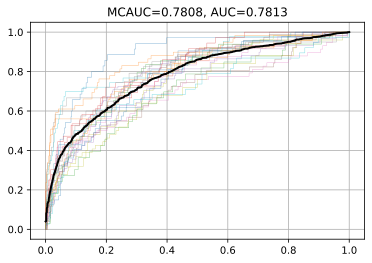

In [297]:
CNN_predict = CNN_model.predict(CNN_X_test)
plot_roc(tagnames, Y_test, CNN_predict)

CNN behave's worse than simple NN, i think its bacause conv1d also can't handle the time sequence well, so next we try the **RNN** which handles sequence data better!

In [417]:
# Simple RNN
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM,SimpleRNN,Embedding
from keras import regularizers

input_shape = (1,X_train.shape[0],X_train.shape[1])



RNN_model = Sequential()
model.add(Embedding(X_train.shape[0],X_train.shape[1]))
RNN_model.add(SimpleRNN(X_train.shape[1])) 
RNN_model.add(Dense(X_train.shape[1], activation='relu'))
# RNN_model.add(Dropout(0.2)) 
RNN_model.add(Dense(22, activation='sigmoid')) #output layer


RNN_X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
RNN_X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))


RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
history = RNN_model.fit(RNN_X_train, Y_train, batch_size=100, epochs=40, verbose=1,validation_data=(RNN_X_test, Y_test))


Epoch 1/40
13/13 [==============================] - 1s 43ms/step - loss: 0.5775 - auc: 0.5255 - val_loss: 0.3870 - val_auc: 0.5536
Epoch 2/40
13/13 [==============================] - 0s 27ms/step - loss: 0.3323 - auc: 0.5510 - val_loss: 0.3047 - val_auc: 0.5859
Epoch 3/40
13/13 [==============================] - 0s 27ms/step - loss: 0.3049 - auc: 0.6079 - val_loss: 0.2950 - val_auc: 0.6069
Epoch 4/40
13/13 [==============================] - 0s 27ms/step - loss: 0.2986 - auc: 0.6074 - val_loss: 0.2952 - val_auc: 0.5943
Epoch 5/40
13/13 [==============================] - 0s 27ms/step - loss: 0.2975 - auc: 0.6126 - val_loss: 0.2939 - val_auc: 0.5997
Epoch 6/40
13/13 [==============================] - 0s 27ms/step - loss: 0.2972 - auc: 0.6131 - val_loss: 0.2944 - val_auc: 0.5926
Epoch 7/40
13/13 [==============================] - 0s 27ms/step - loss: 0.2971 - auc: 0.6141 - val_loss: 0.2939 - val_auc: 0.6008
Epoch 8/40
13/13 [==============================] - 0s 27ms/step - loss: 0.2973 - a

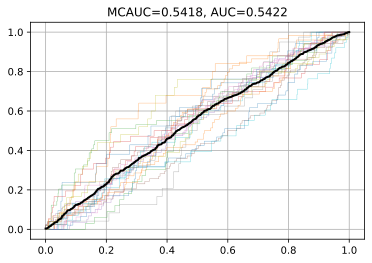

In [413]:
RNN_predict = RNN_model.predict(RNN_X_test)
plot_roc(tagnames, Y_test, RNN_predict)

SimpleRNN performs very bad i think its becasue the embedding parameter is hard to choose, i use the trainset's shape as embed size,maybe this is not good,then  i refer to the doc find that SimpleRNN is not good at handling long sequences

Next, i'll try another kind of RNN: **LSTM**

we use Bidirectional LSTM which always perform better

In [442]:
# LSTM
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional
import numpy as np

LSTM_model = Sequential()
LSTM_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
RNN_model.add(Dropout(0.2)) 
LSTM_model.add(Flatten()) #拉成一维数据
LSTM_model.add(Dense(22, activation='sigmoid')) #output layer


LSTM_X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
LSTM_X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
history = LSTM_model.fit(LSTM_X_train, Y_train, batch_size=100, epochs=50, verbose=1,validation_data=(LSTM_X_test, Y_test))

Epoch 1/50
13/13 [==============================] - 4s 212ms/step - loss: 0.4618 - auc: 0.5131 - val_loss: 0.3125 - val_auc: 0.5973
Epoch 2/50
13/13 [==============================] - 2s 165ms/step - loss: 0.3044 - auc: 0.5915 - val_loss: 0.2947 - val_auc: 0.6014
Epoch 3/50
13/13 [==============================] - 2s 169ms/step - loss: 0.2980 - auc: 0.6127 - val_loss: 0.2933 - val_auc: 0.6058
Epoch 4/50
13/13 [==============================] - 2s 164ms/step - loss: 0.2966 - auc: 0.6198 - val_loss: 0.2932 - val_auc: 0.6083
Epoch 5/50
13/13 [==============================] - 2s 162ms/step - loss: 0.2965 - auc: 0.6224 - val_loss: 0.2940 - val_auc: 0.6134
Epoch 6/50
13/13 [==============================] - 2s 168ms/step - loss: 0.2966 - auc: 0.6195 - val_loss: 0.2934 - val_auc: 0.6050
Epoch 7/50
13/13 [==============================] - 2s 163ms/step - loss: 0.2955 - auc: 0.6301 - val_loss: 0.2923 - val_auc: 0.6153
Epoch 8/50
13/13 [==============================] - 2s 164ms/step - loss: 0.

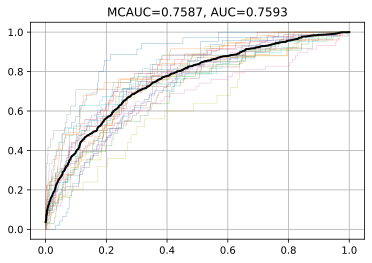

In [440]:
LSTM_predict = LSTM_model.predict(LSTM_X_test)
plot_roc(tagnames, Y_test, LSTM_predict)

among NN, simple NN and CNN performs better than others, but the best performance is merely higher than baseline

Then we try the algorithm learned in class by sklearn to see their baseline performance

For multi-label probelm, i checked the sklearn doc and found these algorithms are suppportable:


**sklearn.tree.DecisionTreeClassifier**

**sklearn.tree.ExtraTreeClassifier**

**sklearn.ensemble.ExtraTreesClassifier**

**sklearn.neighbors.KNeighborsClassifier**

**sklearn.neural_network.MLPClassifier**

**sklearn.neighbors.RadiusNeighborsClassifier**

**sklearn.ensemble.RandomForestClassifier**

**sklearn.linear_model.RidgeClassifierCV**


we can easily tell that one decision tree and knn is obviously not good for this dataset,so we choose MLP RF and RidegeClassfier to see the performance

Fitting 5 folds for each of 60 candidates, totalling 300 fits


G:\andconda\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


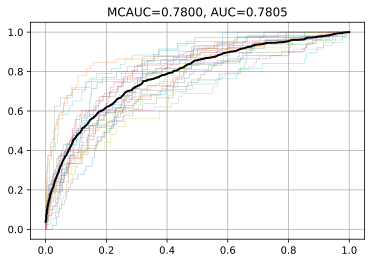

In [328]:
# MLP
from sklearn.neural_network import MLPClassifier

paramgrid = {'alpha': [1e-5,1e-4,1e-3,1e-2],
             'hidden_layer_sizes': [(10,5),(20,10),(40,20),(50,20),(100,50)],
            'solver':['lbfgs', 'sgd', 'adam'],}
mlp = MLPClassifier( random_state=1)

clf = model_selection.GridSearchCV(mlp, paramgrid, cv=5,
                                     n_jobs=-1, verbose=True)
clf.fit(X_train, Y_train)

# 测试集验证
predY_test = clf.predict_proba(X_test)
plot_roc(tagnames, Y_test, predY_test)

MLP can get 0.78 which is  not bad, next we test randomForest

the predict_proba output of RF is incompatiable with the plot_roc function, so we write a transform_proba function

Fitting 5 folds for each of 1 candidates, totalling 5 fits


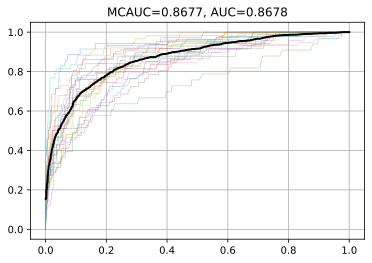

In [497]:
# RF
from sklearn.ensemble import RandomForestClassifier

# rf_paramsampler = { 'n_estimators':[50,100,200,500,1000]
# #                    'min_samples_split': stats.uniform(0,0.5), 
# #                    'min_samples_leaf':  stats.uniform(0,0.5)
#                   }
rf_paramsampler = {}
rfc = model_selection.GridSearchCV(
                            ensemble.RandomForestClassifier(n_estimators = 2000,n_jobs=-1),
                            rf_paramsampler, cv=5, 
                            verbose=1, n_jobs=-1)

rfc.fit(X_train, Y_train)

# output probabilty format transform
def transform_proba(predict):
    transformed_predY_test = zeros(shape=(predict[0].shape[0], len(tagnames)))

    for i in range(len(tagnames)):
        for j in range(predict[0].shape[0]):
            transformed_predY_test[j][i] = predict[i][j][1]
    return transformed_predY_test
            
# 测试集验证
predY_test = rfc.predict_proba(X_test)


plot_roc(tagnames, Y_test, transform_proba(predY_test))

In [462]:
# test the baseline algorithm  in kaggle for RF

rfc.fit(X, y)
test_predict = rfc.predict_proba(test_Xtf.toarray())
write_csv_kaggle_tags("sounds_test_kaggle_bow_baseline.csv", tagnames, transform_proba(test_predict))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


After tuning the paratmeter,we are suprisingly to get 0.86-0.87 on trainingset and 0.84 on kaggle

the performance of RF is incredialy high for i hasn't do anything else like DR,and RF can prevent overfitting to some extend

next we will try RidegeClassfier

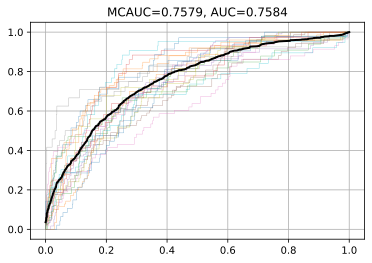

In [406]:
# RidegeClassfier

rc = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)

rc.fit(X_train, Y_train)

# 测试集验证
predY_test = rc.predict(X_test)


plot_roc(tagnames, Y_test, predY_test)

RidegeClassfier performs not good,i think its because RidegeClassfier's underlying principle is too simple to hanlde this kind of dataset

Atfer trying servral models, i think its time to do some demension reduce by algorithms learned from class to see whether it improve the perfomance: PCA KPCA 


Fitting 5 folds for each of 1 candidates, totalling 5 fits


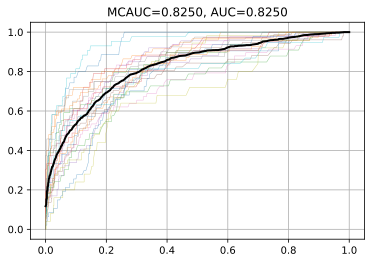

In [458]:
# PCA
pca = decomposition.PCA(n_components=80)
W  = pca.fit_transform(X_train)  # fit the training set
Wt = pca.transform(X_test)  # use the pca model to transform the test set

# RF
# rf_paramsampler = { 'n_estimators':[50,100,200,500,1000]
# #                    'min_samples_split': stats.uniform(0,0.5), 
# #                    'min_samples_leaf':  stats.uniform(0,0.5)
#                   }
rf_paramsampler = {}
rfc = model_selection.GridSearchCV(
                            ensemble.RandomForestClassifier(n_estimators = 1500,n_jobs=-1),
                            rf_paramsampler, cv=5, 
                            verbose=1, n_jobs=-1)

rfc.fit(W, Y_train)

# output probabilty format transform
def transform_proba(predict):
    transformed_predY_test = zeros(shape=(predict[0].shape[0], len(tagnames)))

    for i in range(len(tagnames)):
        for j in range(predict[0].shape[0]):
            transformed_predY_test[j][i] = predict[i][j][1]
    return transformed_predY_test
            
# 测试集验证
predY_test = rfc.predict_proba(Wt)


plot_roc(tagnames, Y_test, transform_proba(predY_test))


PCA decrease the AUC,we try KPCA

Fitting 5 folds for each of 1 candidates, totalling 5 fits


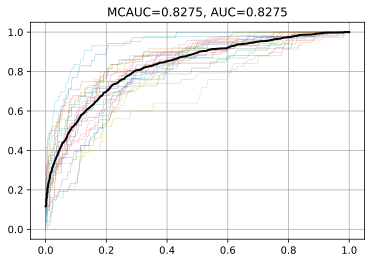

In [459]:
# KPCA
kpca = decomposition.KernelPCA(n_components=70, kernel='rbf', gamma=0.15)
kW  = kpca.fit_transform(X_train)  # fit the training set
kWt = kpca.transform(X_test)  # use the pca model to transform the test set

# RF
# rf_paramsampler = { 'n_estimators':[50,100,200,500,1000]
# #                    'min_samples_split': stats.uniform(0,0.5), 
# #                    'min_samples_leaf':  stats.uniform(0,0.5)
#                   }
rf_paramsampler = {}
rfc = model_selection.GridSearchCV(
                            ensemble.RandomForestClassifier(n_estimators = 1500,n_jobs=-1),
                            rf_paramsampler, cv=5, 
                            verbose=1, n_jobs=-1)

rfc.fit(kW, Y_train)

# output probabilty format transform
def transform_proba(predict):
    transformed_predY_test = zeros(shape=(predict[0].shape[0], len(tagnames)))

    for i in range(len(tagnames)):
        for j in range(predict[0].shape[0]):
            transformed_predY_test[j][i] = predict[i][j][1]
    return transformed_predY_test
            
# 测试集验证
predY_test = rfc.predict_proba(kWt)


plot_roc(tagnames, Y_test, transform_proba(predY_test))

maybe demension reduce can improve the training speed but in this case it's likely to decrease the result

In given pre-process, it use k-means to do clustering. we will try different number of clusters and try GMM、 N-cut... to do clustering 

**since RF among all the models performs best,so we will all use rf to test the new cluster model**

here is what we are gonna do for data processing:


**1) try GMM、DPG、N-cut model**

**2）try new clustering model: DBSCAN**

**3) k-means、tdidf parameter adujsting**


GMM have several covariance_type which is important for clustering. the 'full' type(d*d) is  time comsuing but can result in the most ellipse cluster. in our case, based on subsample ratio 0.1, the full type require more than 1 hour to train the data, so we use 'diag'type(d) which may performs worse but much more faster

In [54]:
# GMM
gmmf = mixture.GaussianMixture(n_components=200, covariance_type='full',n_init = 3,
                               random_state=4487)
gmmf.fit(all_dmfccs[0::5]) 

def bow_transform_GMM(model, mfccs):
    numwords = model.means_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

train_bow = bow_transform_GMM(gmmf, train_dmfccs)
test_bow  = bow_transform_GMM(gmmf, test_dmfccs)

# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

X = train_Xtf.toarray()
y = train_classes
assert X.shape[0] == y.shape[0]
# 把数据集分为训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=11,shuffle=True)

# RF test
# rf_paramsampler = { 'n_estimators':[50,100,200,500,1000]
# #                    'min_samples_split': stats.uniform(0,0.5), 
# #                    'min_samples_leaf':  stats.uniform(0,0.5)
#                   }
rf_paramsampler = {}
rfc = model_selection.GridSearchCV(
                            ensemble.RandomForestClassifier(n_estimators = 2000,n_jobs=-1),
                            rf_paramsampler, cv=5, 
                            verbose=1, n_jobs=-1)

rfc.fit(X_train, Y_train)

# output probabilty format transform
def transform_proba(predict):
    transformed_predY_test = zeros(shape=(predict[0].shape[0], len(tagnames)))

    for i in range(len(tagnames)):
        for j in range(predict[0].shape[0]):
            transformed_predY_test[j][i] = predict[i][j][1]
    return transformed_predY_test
            
# 测试集验证
predY_test = rfc.predict_proba(X_test)


plot_roc(tagnames, Y_test, transform_proba(predY_test))

KeyboardInterrupt: 

In [52]:
# test the baseline algorithm  in kaggle for GMM+RF
rfc.fit(X, y)
test_predict = rfc.predict_proba(test_Xtf.toarray())
write_csv_kaggle_tags("sounds_test_kaggle_bow_baseline.csv", tagnames, transform_proba(test_predict))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GMM reachs 0.89 AUC which performs way better than I expected!!

In K-means, the kaggle AUC is normally 0.02-0.03 lower than local testdata AUC. But for GMM,the local AUC is 0.885 while kaggle AUC is 0.893 which is even higher than local AUC. This revals that the GMM model can handel noise and culster the data better. the only disadvantage is that if we choose full covariance_type, training can be very time-consuming

Next, we try the DPGMM to let model find the best K

G:\andconda\envs\tf\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


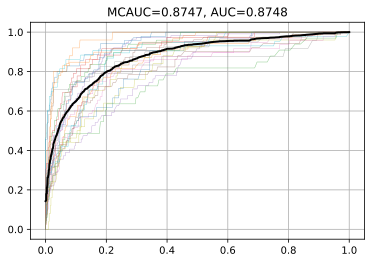

In [525]:
# DPG
dpgmm = mixture.BayesianGaussianMixture(covariance_type='diag', 
                   weight_concentration_prior=1, 
                   n_components=200, max_iter=200,n_init = 3,random_state=4487)

dpgmm.fit(all_dmfccs[0::10]) 

def bow_transform_DPGM(model, mfccs):
    numwords = model.means_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

train_bow = bow_transform_DPGM(dpgmm, train_dmfccs)
test_bow  = bow_transform_DPGM(dpgmm, test_dmfccs)

# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

X = train_Xtf.toarray()
y = train_classes
assert X.shape[0] == y.shape[0]
# 把数据集分为训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=11,shuffle=True)

# RF test
# rf_paramsampler = { 'n_estimators':[50,100,200,500,1000]
# #                    'min_samples_split': stats.uniform(0,0.5), 
# #                    'min_samples_leaf':  stats.uniform(0,0.5)
#                   }
rf_paramsampler = {}
rfc = model_selection.GridSearchCV(
                            ensemble.RandomForestClassifier(n_estimators = 2000,n_jobs=-1),
                            rf_paramsampler, cv=5, 
                            verbose=1, n_jobs=-1)

rfc.fit(X_train, Y_train)

# output probabilty format transform
def transform_proba(predict):
    transformed_predY_test = zeros(shape=(predict[0].shape[0], len(tagnames)))

    for i in range(len(tagnames)):
        for j in range(predict[0].shape[0]):
            transformed_predY_test[j][i] = predict[i][j][1]
    return transformed_predY_test
            
# 测试集验证
predY_test = rfc.predict_proba(X_test)


plot_roc(tagnames, Y_test, transform_proba(predY_test))

dpgmm performs nearly to gmm

Next we try N-cut. Since N-cut is graph-based clustering, the subsample ratio of 0.1 is still too big to construct the graph(Unable to allocate array with shape (78364, 78364) ) so we can only decrease the subsample ratio.But after that we find that cluster models dont have predict function. so we can only write our own predict function?

In [26]:
# specture clsutering(N-cut)

sc = cluster.SpectralClustering(n_clusters=100, affinity='rbf',
                                gamma=1.0, assign_labels='discretize',n_init = 3, n_jobs=-1,verbose = 1)

sc.fit(all_dmfccs[0::50]) 

def bow_transform_SC(model, mfccs):
    numwords = model.means_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

train_bow = bow_transform_SC(sc, train_dmfccs)
test_bow  = bow_transform_SC(sc, test_dmfccs)

# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

X = train_Xtf.toarray()
y = train_classes
assert X.shape[0] == y.shape[0]
# 把数据集分为训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=11,shuffle=True)

# RF test
# rf_paramsampler = { 'n_estimators':[50,100,200,500,1000]
# #                    'min_samples_split': stats.uniform(0,0.5), 
# #                    'min_samples_leaf':  stats.uniform(0,0.5)
#                   }
rf_paramsampler = {}
rfc = model_selection.GridSearchCV(
                            ensemble.RandomForestClassifier(n_estimators = 2000,n_jobs=-1),
                            rf_paramsampler, cv=5, 
                            verbose=1, n_jobs=-1)

rfc.fit(X_train, Y_train)

# output probabilty format transform
def transform_proba(predict):
    transformed_predY_test = zeros(shape=(predict[0].shape[0], len(tagnames)))

    for i in range(len(tagnames)):
        for j in range(predict[0].shape[0]):
            transformed_predY_test[j][i] = predict[i][j][1]
    return transformed_predY_test
            
# 测试集验证
predY_test = rfc.predict_proba(X_test)


plot_roc(tagnames, Y_test, transform_proba(predY_test))

G:\andconda\envs\tf\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [30]:
# DBSCAN
import scipy as sp
import numpy as np

def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance.cosine):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

ds = cluster.DBSCAN(eps = 0.1,min_samples = 10, n_jobs=-1)

ds.fit(all_dmfccs[0::10]) 

dbscan_predict(ds,train_dmfccs)
               
# def bow_transform_DS(model, mfccs):
#     numwords = model.components_.shape[1]
#     bows = zeros((len(mfccs), numwords))
#     for i in range(len(mfccs)):
#         w = model.predict(mfccs[i])
#         bw = bincount(w, minlength=numwords)
#         bows[i,:] = bw
#     return bows

# train_bow = bow_transform_DS(ds, train_dmfccs)
# test_bow  = bow_transform_DS(ds, test_dmfccs)

# # convert to TF
# tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l2')
# train_Xtf = tf_trans.fit_transform(train_bow)
# test_Xtf  = tf_trans.transform(test_bow)

# X = train_Xtf.toarray()
# y = train_classes
# assert X.shape[0] == y.shape[0]
# # 把数据集分为训练集和验证集
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=11,shuffle=True)

# # RF test
# # rf_paramsampler = { 'n_estimators':[50,100,200,500,1000]
# # #                    'min_samples_split': stats.uniform(0,0.5), 
# # #                    'min_samples_leaf':  stats.uniform(0,0.5)
# #                   }
# rf_paramsampler = {}
# rfc = model_selection.GridSearchCV(
#                             ensemble.RandomForestClassifier(n_estimators = 2000,n_jobs=-1),
#                             rf_paramsampler, cv=5, 
#                             verbose=1, n_jobs=-1)

# rfc.fit(X_train, Y_train)

# # output probabilty format transform
# def transform_proba(predict):
#     transformed_predY_test = zeros(shape=(predict[0].shape[0], len(tagnames)))

#     for i in range(len(tagnames)):
#         for j in range(predict[0].shape[0]):
#             transformed_predY_test[j][i] = predict[i][j][1]
#     return transformed_predY_test
            
# # 测试集验证
# predY_test = rfc.predict_proba(X_test)


# plot_roc(tagnames, Y_test, transform_proba(predY_test))

NameError: name 'strain_dmfccs' is not defined

In [41]:
# PCA
pca = decomposition.PCA(n_components=15)
W  = pca.fit_transform(train_dmfccs)  # fit the training set
Wt = pca.transform(test_dmfccs)  # use the pca model to transform the test set

ValueError: setting an array element with a sequence.

i cant write the proper output function for Ncut and DBSCAN due to the time, so i move to the next step:adjusting Kmeans/GMM + TFIDF + RF paramteters. this step can be seen in Assignment2-final.ipynb
    

For demension reduce, i thought about implement DR on all_Mfcc but refer to the internet that DR works bad on time sequence data,so i only tried apply DR after TFIDF which has no positive influence as shown before

### Conclusion

During this multi-label experiement, fisrtly high demension of MFCC with time sequence and bag-of-aduio data make me believe that NN models with keras will perform best.But after trying simple NN、CNN、RNN（bi LSTM）,the best perfomance is only 0.8. Then i think i will try the traditional models which support the multi-labl problem like MLP、RandomForest、RidgeClassfier. it's surprisingly to find that TF can get 0.85 AUC.So we choose RF as the default algorithm,and then consider the data-processing like DR or other clustering model like GMM、DPGMM.. with adjusting the parameters, we find that GMM+TFIDF+RF get the best result
